# freud.density.RDF: Choosing Bin Widths
The `freud.density` module is intended to compute a variety of quantities that relate spatial distributions of particles with other particles.
This example demonstrates the calculation of the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function) $g(r)$ using different bin sizes.

In [1]:
import freud
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define some helper plotting functions.


def plot_rdf(box, points, prop, r_max=3.5, bins_array=[20, 75, 3000]):
    """Helper function for plotting RDFs."""
    fig, axes = plt.subplots(1, len(bins_array), figsize=(16, 3))
    for i, bins in enumerate(bins_array):
        rdf = freud.density.RDF(bins, r_max)
        rdf.compute(system=(box, points))
        axes[i].plot(rdf.bin_centers, getattr(rdf, prop))
        axes[i].set_title(f"Bin width: {r_max/bins:.3f}", fontsize=16)
    plt.show()

To start, we construct and visualize a set of points sitting on a simple square lattice.

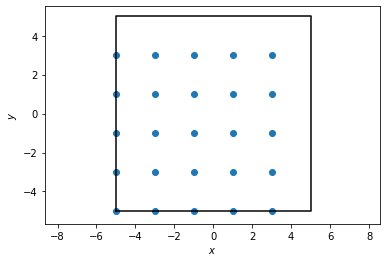

In [3]:
box, points = freud.data.UnitCell.square().generate_system(5, scale=2)
aq = freud.AABBQuery(box, points)
aq.plot(ax=plt.gca())
plt.show()

If we try to compute the RDF directly from this, we will get something rather uninteresting since we have a perfect crystal.
Indeed, we will observe that as we bin more and more finely, we approach the true behavior of the RDF for perfect crystals, which is a simple delta function.

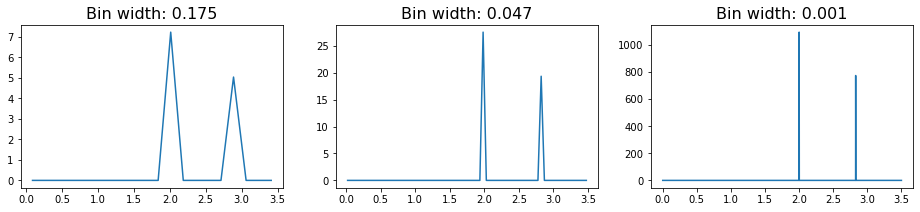

In [4]:
plot_rdf(box, points, "rdf")

In these RDFs, we see two sharply defined peaks, with the first corresponding to the nearest neighbors on the lattice (which are all at a distance 2 from each other), and the second, smaller peak caused by the particles on the diagonal (which sit at distance $\sqrt{2^2+2^2} \approx 2.83$.

However, in more realistic systems, we expect that the lattice will not be perfectly formed.
In this case, the RDF will exhibit more features.
To demonstrate this fact, we reconstruct the square lattice of points from above, but we now introduce some noise into the system.

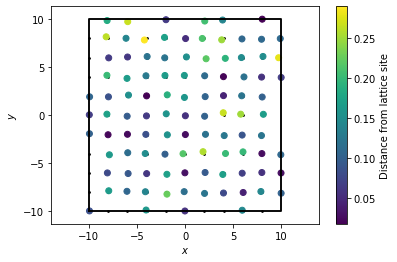

In [5]:
box, clean_points = freud.data.UnitCell.square().generate_system(
    10, scale=2, sigma_noise=0
)
box, noisy_points = freud.data.UnitCell.square().generate_system(
    10, scale=2, sigma_noise=0.1
)
aq_clean = freud.AABBQuery(box, clean_points)
aq_clean.plot(ax=plt.gca(), c="k", s=3)
aq_noisy = freud.AABBQuery(box, noisy_points)
deviations = np.linalg.norm(box.wrap(noisy_points - clean_points), axis=-1)
_, sc = aq_noisy.plot(ax=plt.gca(), c=deviations)
cbar = plt.colorbar(sc)
cbar.set_label("Distance from lattice site")
plt.show()

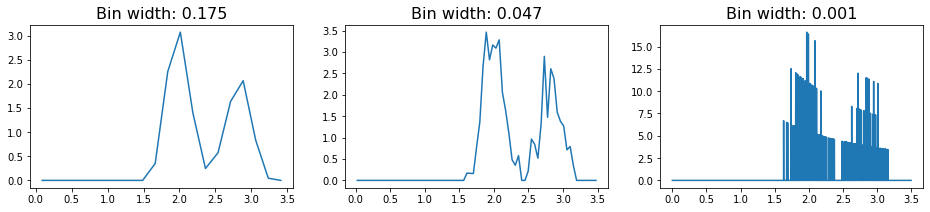

In [6]:
plot_rdf(box, noisy_points, "rdf")

In this RDF, we see the same rough features as we saw with the perfect lattice.
However, the signal is much noisier, and in fact we see that increasing the number of bins essentially leads to overfitting of the data.
As a result, we have to be careful with how we choose to bin our data when constructing the RDF object.

An alternative route for avoiding this problem can be using the cumulative RDF instead.
The relationship between the cumulative RDF and the RDF is akin to that between a cumulative density and a probability density function, providing a measure of the total density of particles experienced up to some distance rather than the value at that distance.
Just as a CDF can help avoid certain mistakes common to plotting a PDF, plotting the cumulative RDF may be helpful in some cases.
Here, we see that decreasing the bin size slightly alters the features of the plot, but only in very minor way (*i.e.* decreasing the smoothness of the line due to small jitters).

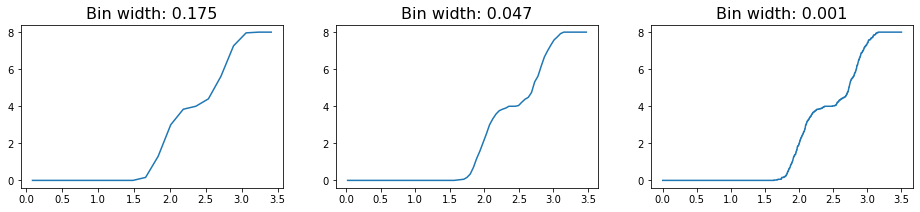

In [7]:
plot_rdf(box, noisy_points, "n_r")